# Saliency Evaluation using DeepGaze I
This notebook evaluates saliency maps predicted by the DeepGaze I model on TD and ASD image datasets using AUC-Judd, AUC-Shuffled, and NSS metrics.

In [ ]:
# Clone DeepGaze repository
!git clone https://github.com/matthias-k/DeepGaze.git

# Add DeepGaze to Python path
import sys
sys.path.append("/content/DeepGaze/deepgaze_pytorch")


Cloning into 'DeepGaze'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 142 (delta 7), reused 2 (delta 2), pack-reused 132 (from 1)
Receiving objects: 100% (142/142), 892.66 KiB | 2.51 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [ ]:
import os
import numpy as np
import cv2
import torch
from sklearn.metrics import roc_auc_score

Open deepgaze1.py and change:

from .features.alexnet import RGBalexnet


from .modules import FeatureExtractor, Finalizer, DeepGazeII as TorchDeepGazeII



To:

from features.alexnet import RGBalexnet



from modules import FeatureExtractor, Finalizer, DeepGazeII as TorchDeepGazeII

Open modules.py and change this line:

Old:

from .layers import GaussianFilterNd

New:


from layers import GaussianFilterNd

In [ ]:
# Add DeepGaze to the Python path
import sys
sys.path.append("/content/DeepGaze/deepgaze_pytorch")

# Now import the model
from deepgaze1 import DeepGazeI

In [ ]:
# upload the Saliency4asd.zip in the google colab file section

In [ ]:
!unzip /content/Saliency4asd.zip -d /content/


Archive:  /content/Saliency4asd.zip
  inflating: /content/Saliency4asd/TD_FixMaps/11_s.png  
  inflating: /content/Saliency4asd/TD_FixMaps/117_s.png  
  inflating: /content/Saliency4asd/TD_FixMaps/109_s.png  
  inflating: /content/Saliency4asd/TD_FixMaps/113_s.png  
  inflating: /content/Saliency4asd/TD_FixMaps/116_s.png  
  inflating: /content/Saliency4asd/TD_FixMaps/101_s.png  
  inflating: /content/Saliency4asd/TD_FixMaps/112_s.png  
  inflating: /content/Saliency4asd/TD_FixMaps/104_s.png  
  inflating: /content/Saliency4asd/TD_FixMaps/100_s.png  
  inflating: /content/Saliency4asd/TD_FixMaps/110_s.png  
  inflating: /content/Saliency4asd/TD_FixMaps/114_s.png  
  inflating: /content/Saliency4asd/TD_FixMaps/111_s.png  
  inflating: /content/Saliency4asd/TD_FixMaps/108_s.png  
  inflating: /content/Saliency4asd/TD_FixMaps/103_s.png  
  inflating: /content/Saliency4asd/TD_FixMaps/121_s.png  
  inflating: /content/Saliency4asd/TD_FixPts/105_f.png  
  inflating: /content/Saliency4asd/TD_

In [ ]:
import os
import cv2
import numpy as np
import torch
from torchvision import transforms
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

# Set device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepGazeI(pretrained=True).to(device)
model.eval()

# ---------- Preprocessing ----------
def preprocess_image(img):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)

def normalize_map(smap):
    smap = cv2.resize(smap, (224, 224))
    smap = (smap - np.min(smap)) / (np.max(smap) - np.min(smap) + 1e-8)
    return smap

# ---------- Metrics ----------
def NSS(smap, fmap):
    smap = normalize_map(smap)
    smap = (smap - smap.mean()) / (smap.std() + 1e-8)
    return np.mean(smap[fmap > 0])

def AUC_Judd(smap, fmap):
    smap = normalize_map(smap).flatten()
    fmap = fmap.flatten()
    if np.sum(fmap) == 0:
        return np.nan
    return roc_auc_score(fmap, smap)

def AUC_Shuffled(smap, fmap, all_other_fix):
    smap = normalize_map(smap).flatten()
    fix = fmap.flatten()
    other_fix = np.sum(all_other_fix, axis=0).flatten()
    true_vals = smap[fix > 0]
    false_vals = smap[other_fix > 0]
    if len(true_vals) == 0 or len(false_vals) == 0:
        return np.nan
    labels = np.concatenate([np.ones_like(true_vals), np.zeros_like(false_vals)])
    scores = np.concatenate([true_vals, false_vals])
    return roc_auc_score(labels, scores)

# ---------- Dataset Paths ----------
base_path = "/content/Saliency4asd"
img_dir = os.path.join(base_path, "Images")
td_dir = os.path.join(base_path, "TD_FixMaps")
asd_dir = os.path.join(base_path, "ASD_FixMaps")
image_files = sorted(os.listdir(img_dir))

# ---------- Load all TD fixation maps for AUC_Shuffled ----------
all_td_fix = []
for fname in image_files:
    td_path = os.path.join(td_dir, fname)
    fmap = cv2.imread(td_path, 0)
    if fmap is not None:
        fmap = (fmap > 0).astype(np.uint8)  # Binarize fixation
        all_td_fix.append(fmap)

# ---------- Initialize Results ----------
results = {
    "TD": {"NSS": [], "AUC_Judd": [], "AUC_Shuffled": []},
    "ASD": {"NSS": [], "AUC_Judd": [], "AUC_Shuffled": []}
}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Image loaded: True
✅ TD fix map loaded: False
✅ ASD fix map loaded: False


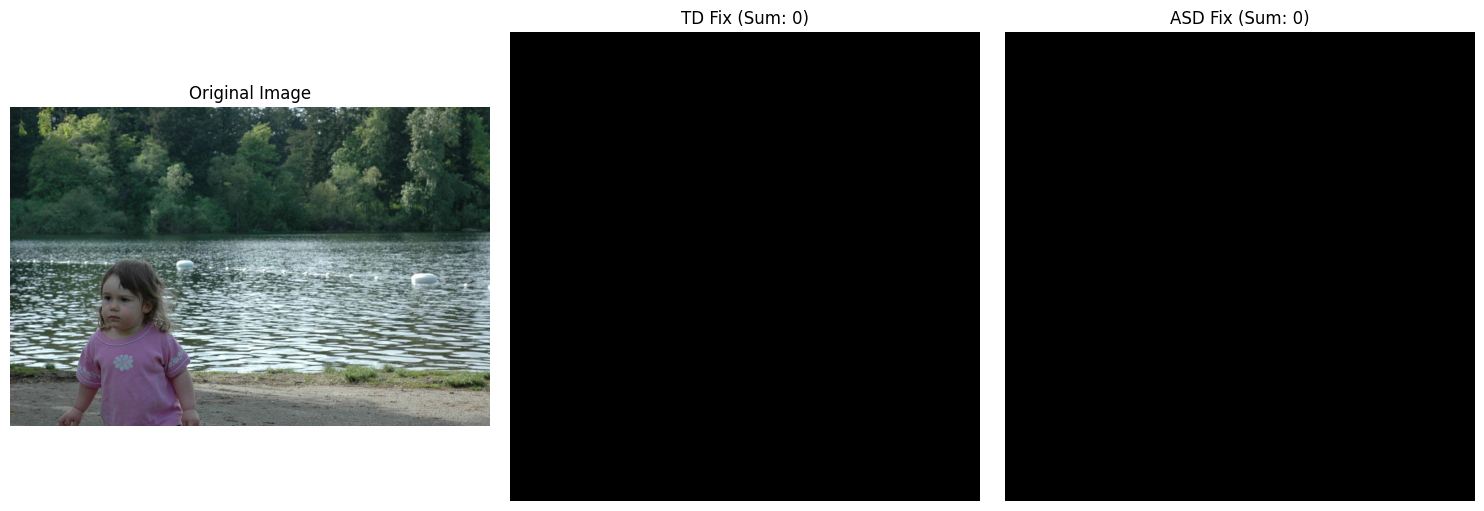

In [ ]:
import matplotlib.pyplot as plt

# Pick sample file
img_path = os.path.join(img_dir, image_files[0])
td_path = os.path.join(td_dir, image_files[0])
asd_path = os.path.join(asd_dir, image_files[0])

# Read
img = cv2.imread(img_path)
td_fix = cv2.imread(td_path, 0)
asd_fix = cv2.imread(asd_path, 0)

# Validate loading
print("Image loaded:", img is not None)
print("TD fix map loaded:", td_fix is not None)
print("ASD fix map loaded:", asd_fix is not None)

# Default fallback arrays if any are None
if td_fix is None:
    td_fix = np.zeros((224, 224), dtype=np.uint8)
if asd_fix is None:
    asd_fix = np.zeros((224, 224), dtype=np.uint8)

# Fix dtypes for imshow compatibility
td_fix = td_fix.astype(np.uint8)
asd_fix = asd_fix.astype(np.uint8)

# Show results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")

axs[1].imshow(td_fix, cmap='gray')
axs[1].set_title(f"TD Fix (Sum: {np.sum(td_fix)})")

axs[2].imshow(asd_fix, cmap='gray')
axs[2].set_title(f"ASD Fix (Sum: {np.sum(asd_fix)})")

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:

# ---------- Main Evaluation Loop ----------
for fname in tqdm(image_files):
    img_path = os.path.join(img_dir, fname)
    td_path = os.path.join(td_dir, fname)
    asd_path = os.path.join(asd_dir, fname)

    img = cv2.imread(img_path)
    if img is None:
        continue

    inp = preprocess_image(img).to(device)

    with torch.no_grad():
        feat_out = model.features(inp)[0]
        _, _, H, W = feat_out.shape

        centerbias = torch.zeros((1, H, W)).to(device)  # CORRECT shape (1, H, W)

        output = model(inp, centerbias=centerbias)
        pred = output.cpu().numpy()[0, 0]  # 2D saliency map

    # ---------- Load and Binarize Fixation Maps ----------
    td_fix = cv2.imread(td_path, 0)
    asd_fix = cv2.imread(asd_path, 0)
    if td_fix is None or asd_fix is None:
        continue

    td_fix = (td_fix > 0).astype(np.uint8)   # Binary fixations
    asd_fix = (asd_fix > 0).astype(np.uint8) # Binary fixations

    # ---------- TD Evaluation ----------
    results["TD"]["NSS"].append(NSS(pred, td_fix))
    results["TD"]["AUC_Judd"].append(AUC_Judd(pred, td_fix))
    results["TD"]["AUC_Shuffled"].append(AUC_Shuffled(pred, td_fix, all_td_fix))

    # ---------- ASD Evaluation ----------
    results["ASD"]["NSS"].append(NSS(pred, asd_fix))
    results["ASD"]["AUC_Judd"].append(AUC_Judd(pred, asd_fix))
    results["ASD"]["AUC_Shuffled"].append(AUC_Shuffled(pred, asd_fix, all_td_fix))

# ---------- Print Final Scores ----------
for group in ["TD", "ASD"]:
    print(f"\n📊 Results for {group}:")
    for metric in ["NSS", "AUC_Judd", "AUC_Shuffled"]:
        values = [v for v in results[group][metric] if not np.isnan(v)]
        print(f"{metric}: {np.mean(values):.4f}")

100%|██████████| 300/300 [00:51<00:00,  5.81it/s]


📊 Results for TD:
NSS: nan
AUC_Judd: nan
AUC_Shuffled: nan

📊 Results for ASD:
NSS: nan
AUC_Judd: nan
AUC_Shuffled: nan
